# Rewriting the code in PyTorch

TODO insert line for installing necessary libs and run the final model in a Google Colab notebook to minimize train time (dont wanna wait)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from typing import Any, List, Optional

%matplotlib inline

In [2]:
with open("names.txt", "r") as file:
    words = file.read().splitlines()

chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")

block_size = 3  # context length: how many characters do we take to predict the next one


def build_dataset(words):

    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    # basically we have a rolling window for context
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Vocabulary size: 27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [3]:
import abc


class Layer(abc.ABC):
    @abc.abstractmethod
    def __call__(self, x: torch.tensor) -> torch.tensor:
        pass

    @abc.abstractmethod
    def parameters() -> List[torch.tensor]:
        pass

In [54]:
g = torch.Generator().manual_seed(2147483647)


class Linear(Layer):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        device: Optional[str] = None,
    ) -> None:
        self.weights = torch.randn((in_features, out_features), generator=g) # / in_features ** 0.5
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:

        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> List[torch.tensor]:
        return [self.weights] + ([] if self.bias is None else [self.bias])


class BatchNorm1d(Layer):
    def __init__(
        self,
        num_features: int,
        eps: float = 1e-5,
        momentum: float = 0.1,
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, x: torch.tensor) -> torch.tensor:
        # calculate the forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:  # inference
            xmean = self.running_mean
            xvar = self.running_std

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = xhat * self.gamma + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self) -> List[torch.tensor]:
        return [self.gamma, self.beta]


class Tanh(Layer):
    def __init__(self) -> None:
        pass

    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> Optional[List]:
        return []

In [55]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP


C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(block_size * n_embd, n_hidden, bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=True),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

# NOTE: there are similar results when placing batchnorm after activation layers

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weights *= 0.1
    layers[-1].gamma *= 0.1  # if we make batch norm the last layer
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 1.0 # 5 / 3     # this boosts initialization values of the weights by the gain (for tanh its 5/3)


parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(f"Total num of elements: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Total num of elements: 47551


In [56]:
n_epochs = 200000
batch_size = 32
lossi = []

for i in range(n_epochs):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xbatch, Ybatch = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xbatch]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, target=Ybatch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph

    for p in parameters:
        p.grad = None
    loss.backward()

    # parameter update
    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{n_epochs:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2870


Layer 2 Tanh: mean -0.01, std 0.63, saturated 3.69
Layer 5 Tanh: mean -0.00, std 0.64, saturated 2.59
Layer 8 Tanh: mean -0.00, std 0.64, saturated 2.66
Layer 11 Tanh: mean +0.00, std 0.64, saturated 2.78
Layer 14 Tanh: mean -0.00, std 0.64, saturated 2.72


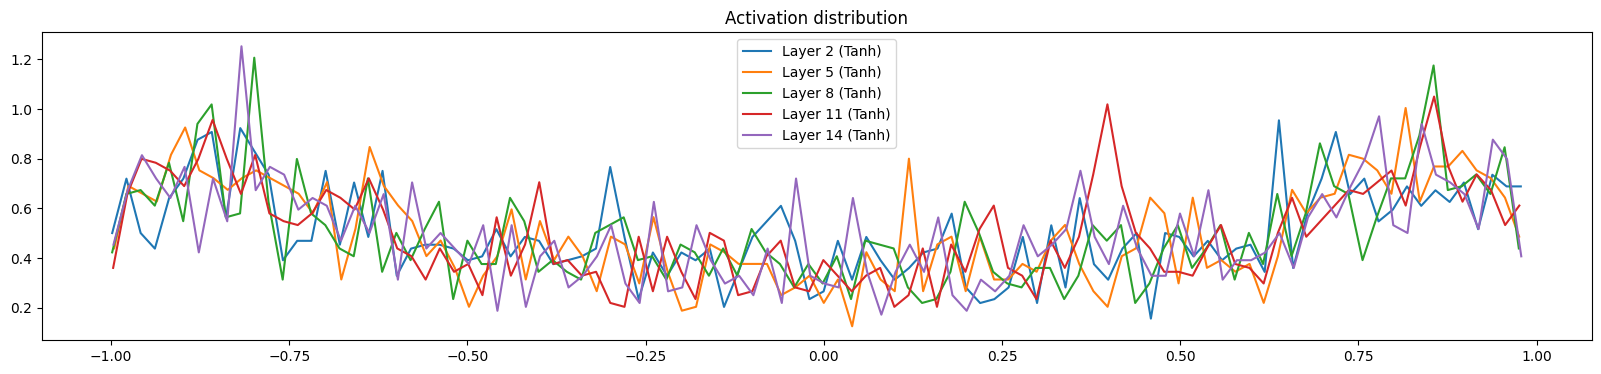

In [57]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t: torch.tensor = layer.out
        print(f"Layer {i} {layer.__class__.__name__}: mean {t.mean():+.2f}, std {t.std():.2f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activation distribution");
# When we are in the tails of the tanh that stops gradients so we do not want this to be too high (saturated part)

The tanh (activation function) squash the distribution of the weight values, so some gain is necessary to fight the squashing. 

Layer 2 Tanh: mean -0.00, std 0.00
Layer 5 Tanh: mean +0.00, std 0.00
Layer 8 Tanh: mean -0.00, std 0.00
Layer 11 Tanh: mean +0.00, std 0.00
Layer 14 Tanh: mean +0.00, std 0.00


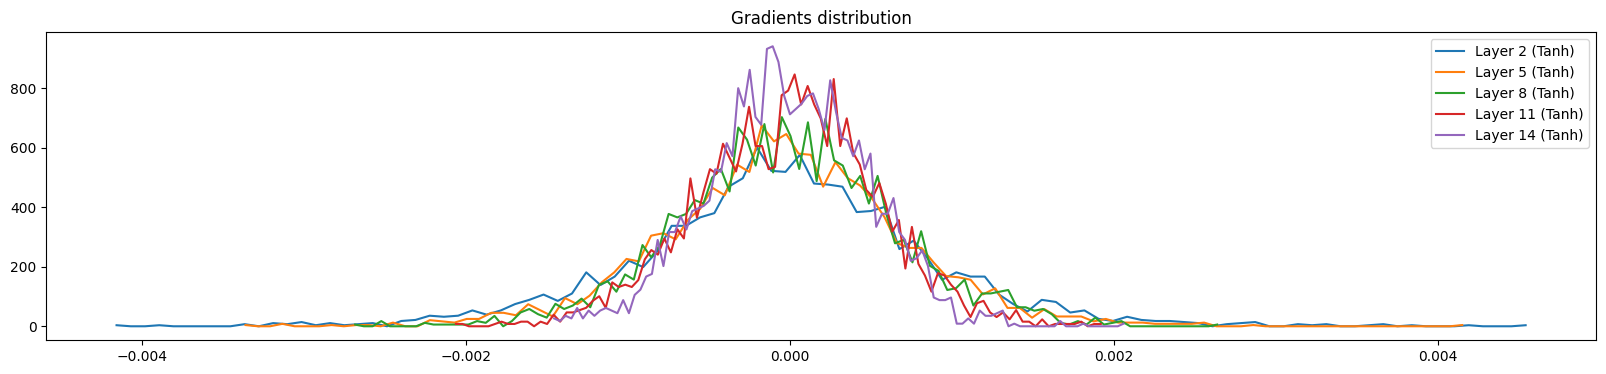

In [58]:
# visualize histograms for GRADIENT distribution
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t: torch.tensor = layer.out.grad
        print(f"Layer {i} {layer.__class__.__name__}: mean {t.mean():+.2f}, std {t.std():.2f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradients distribution");
# When we are in the tails of the tanh that stops gradients so we do not want this to be too high (saturated part)

We have to set a good gain value to get nice values in both the forward and backward pass. (multiply by 5/3 because of tanh activation func in this case)

## No linearity

Removing all tanh actviation functions to have a linear sandwich model, we get a spread out distribution which becomes more and more diminished as we move through the deeper layers. 

If we had 50 layer deep networks, we would not have any gradients in the deeper layers. The correct setting for gain in this case is multiplying it by 1. 

A linear model without activation function with a lot of linear layers collapses into a single linear layer. 

Before optimiziers and normalization techniqes, we had to look at the activatons and gradients. 



## Using batchnorm with no fan-in and gain

We would just need to bump up our learning rate by 10 when looking at the log10 values from the global scale of the learning ratio. 

Use both. 

### Model initialization is still an open question! We have some tools to tell us if things are on the right track. 